In [1]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np

import matplotlib.pyplot as plt

/home/leeh8911/anaconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SAME_DISTRIBUTION = False
HARD_DISTRIBUTION = True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
SEED = 19901109
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

torch.backends.cudnn.benchmark = False

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_datasets = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_datasets = datasets.MNIST('./data', train=False, download=True, transform=transform)

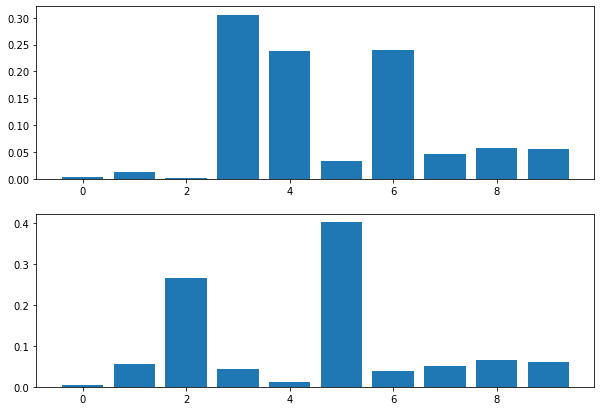

In [6]:
nclass = len(train_datasets.classes)

if SAME_DISTRIBUTION:
    train_dataset_distribution = np.random.rand(nclass)
    test_dataset_distribution = train_dataset_distribution
else:
    train_dataset_distribution = np.random.rand(nclass)
    test_dataset_distribution = np.random.rand(nclass)

if HARD_DISTRIBUTION:
    train_dataset_distribution = train_dataset_distribution ** 3
    test_dataset_distribution = test_dataset_distribution ** 3

train_dataset_distribution /= sum(train_dataset_distribution)
test_dataset_distribution /= sum(test_dataset_distribution)

fig, axes = plt.subplots(2, 1, figsize=(10, 7))
axes[0].bar(range(nclass), train_dataset_distribution)
axes[1].bar(range(nclass), test_dataset_distribution)
plt.show()

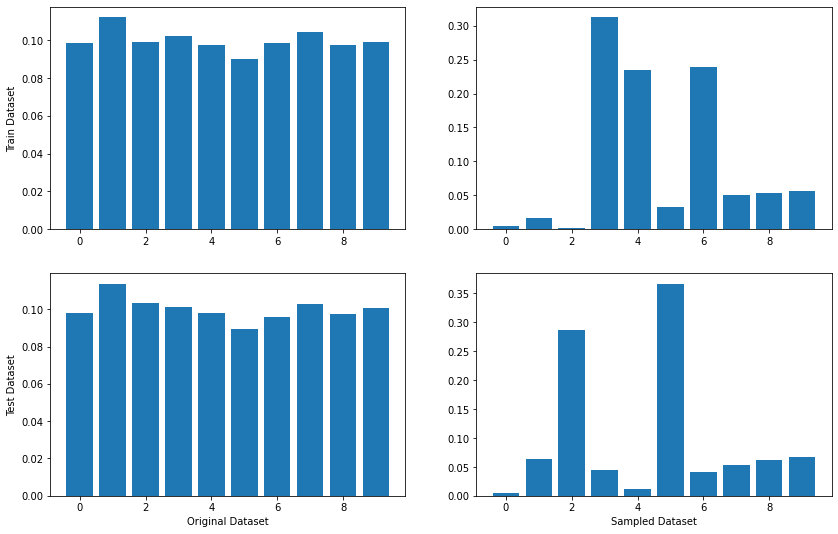

In [7]:
def sampled_datasets(class_weights, dataset):
    data_weight = [class_weights[c] for _, c in dataset]

    sampler = torch.utils.data.WeightedRandomSampler(data_weight, len(dataset))

    samples = [dataset[i] for i in sampler]
    return samples

new_train_datasets = sampled_datasets(train_dataset_distribution, train_datasets)
new_test_datasets = sampled_datasets(test_dataset_distribution, test_datasets)

train_origin_count = np.zeros((nclass, ))
train_new_count = np.zeros((nclass, ))
test_origin_count = np.zeros((nclass, ))
test_new_count = np.zeros((nclass, ))

for _, c in train_datasets:
    train_origin_count[c] += 1

for _, c in new_train_datasets:
    train_new_count[c] += 1

for _, c in test_datasets:
    test_origin_count[c] += 1

for _, c in new_test_datasets:
    test_new_count[c] += 1

train_origin_distribution = train_origin_count / sum(train_origin_count)
train_new_distribution = train_new_count / sum(train_new_count)
test_origin_distribution = test_origin_count / sum(test_origin_count)
test_new_distribution = test_new_count / sum(test_new_count)

fig, axes = plt.subplots(2, 2, figsize=(14, 9))
axes[0][0].bar(range(nclass), train_origin_distribution)
axes[0][1].bar(range(nclass), train_new_distribution)
axes[0][0].set_ylabel("Train Dataset")

axes[1][0].bar(range(nclass), test_origin_distribution)
axes[1][1].bar(range(nclass), test_new_distribution)
axes[1][0].set_ylabel("Test Dataset")
axes[1][0].set_xlabel("Original Dataset")
axes[1][1].set_xlabel("Sampled Dataset")

plt.show()

In [8]:

train_loader = DataLoader(new_train_datasets, batch_size=16, shuffle=True)

fig, axes = plt.subplots(4, 4)
for batch in train_loader:
    for idx, (X, y) in enumerate(zip(*batch)):
        print(X)
        axes[idx % 4][idx // 4].imshow(X.squeeze(0)
        axes[idx % 4][idx // 4].set_xlabel(y)

plt.show()


SyntaxError: invalid syntax (406410557.py, line 8)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 1)
])

train_loader = torch.utils.data.DataLoader(train_datasets, transform=transform, batch_size=batch_size, Ra
    
)